In [1]:
""" Created on May 25, 2021 // @author: Sarah Shi and Bill Menke """

import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc, cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches

from scipy import stats
from scipy.optimize import least_squares
from scipy.optimize import curve_fit
# Using scikit-learn's gradient boosted decision trees
from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('font',**{'family':'Avenir', 'size': 20})
plt.rcParams['pdf.fonttype'] = 42

plt.rcParams["xtick.major.size"] = 4 # Sets length of ticks
plt.rcParams["ytick.major.size"] = 4 # Sets length of ticks
plt.rcParams["xtick.labelsize"] = 18 # Sets size of numbers on tick marks
plt.rcParams["ytick.labelsize"] = 18 # Sets size of numbers on tick marks
plt.rcParams["axes.labelsize"] = 20 # Axes labels

# method treats d, z, m1 and m2 as unknowns. model f(i) = 0 = m1 + m2*z(i) - d(i);
# unknowns:  m1, m2 and the predicted (z,d)'s

In [2]:
def inversion(comp, sigma_comp, epsilon, sigma_epsilon): 

    M = 2
    N = len(comp)

    G = np.array([np.ones(N), comp]).T
    mls = np.linalg.solve(np.dot(G.T, G), np.dot(G.T, epsilon)) 

    # Regular least squares for starting value. 
    covls = np.linalg.inv(np.linalg.multi_dot([G.T, np.diag(sigma_epsilon**-2), G]))

    # A priori solution is least squares solution. xbar is the prior solution of x. 
    # For Tobs, zobs, it is the data. For m, it is the least squares solution. 
    xbar = np.concatenate([epsilon, comp, mls])

    # Trial solution based on least squares 
    xg = xbar

    # Gradient vector, needs to change for multiple parameters. 
    Fg = np.zeros([N, M*N+M])

    # Covariance, large for model parameters 
    covx = np.zeros([M*N+M, M*N+M])

    covx[0*N:1*N, 0*N:1*N] = np.diag(sigma_epsilon**2)
    covx[1*N:2*N, 1*N:2*N] = np.diag(sigma_comp**2)

    scale = 1
    covx[M*N+0, M*N+0] = scale * covls[0, 0]
    covx[M*N+1, M*N+1] = scale * covls[1, 1]

    Nit = 100
    epsilon_pre_all = np.zeros([N, Nit])
    epsilon_linear_all = np.zeros([N, Nit])
    mest_all = np.zeros([2, Nit])

    for i in range(0, Nit): 
        f = -xg[0:N] + (xg[M*N+1]*xg[1*N:2*N]) + (xg[M*N+0]*np.ones(N))
        Ef = np.dot(f.T, f)

        if (i == 0): 
            print('Initial error in implicit equation = ' + str(Ef))
        elif (i%10 == 0): 
            print('Final error in implicit equation = ', Ef)

        Fg[0:N, 0:N] = -np.eye(N, N)
        Fg[0:N, N:2*N] = xg[M*N+1] * np.eye(N, N)

        Fg[0:N, M*N+0] = np.ones([N])
        Fg[0:N, M*N+1] = xg[1*N:2*N]

        epsi = 0
        
        left = Fg.T
        right = np.linalg.multi_dot([Fg, covx, Fg.T]) + (epsi*np.eye(N, N))
        solve = np.linalg.solve(right.conj().T, left.conj().T).conj().T
        MO = np.dot(covx, solve)
        xg2 = xbar + np.dot(MO, (np.dot(Fg,(xg-xbar))-f))
        xg = xg2

        mest = xg[M*N+0:M*N+M]
        epsilon_pre = xg[0:N]
        epsilon_linear = mest[0] + mest[1]*comp
        epsilon_pre_all[0:N, i] = epsilon_pre[0:N]
        mest_all[0:N, i] = mest
        epsilon_linear_all[0:N, i] = epsilon_linear[0:N]

    MO2 = np.dot(MO, Fg)
    covx_est = np.linalg.multi_dot([MO2, covx, MO2.T])

    covepsilon_est_f = covx_est[0:N, 0:N]
    vepsilon = np.diag(covepsilon_est_f)
    E_calib = 2*np.sqrt(np.mean(vepsilon))

    covm_est = covx_est[-2:, -2:]
    vc = covx_est[-2, -2]
    vcomp = covx_est[-1, -1]
    covm_est_f = covm_est

    epsilon_pre = xg[0:1*N]
    comp_pre = xg[1*N:2*N]

    mest_f = xg[M*N:M*N+M]
    epsilon_linear = mest_f[0] + mest_f[1]*comp
    epsilon_ls = mls[0] + mls[1]*comp

    print('mls ' + str(mls))
    print('95% CI ' + str(2*np.sqrt(np.diag(covls))))
    print('mest ' + str(mest_f))
    print('95% CI final ' + str(2*np.sqrt(np.diag(covm_est_f))))

    return mls, mest_f, covls, covm_est_f, covepsilon_est_f, comp_pre, epsilon_pre, epsilon_linear


def errors(comp, epsilon, mls, mest_f, covls, covm_est_f, covepsilon_est_f):

    vepsilon = np.diag(covepsilon_est_f)
    E_calib = 2*np.sqrt(np.mean(vepsilon))

    epsilon_ls = mls[0] + mls[1]*comp
    epsilon_linear = mest_f[0] + mest_f[1]*comp

    res_inv = epsilon_linear - epsilon
    see_inv = np.sqrt(np.sum(res_inv**2)) / (len(res_inv)-1-1)

    yhat_inv = epsilon_linear 
    ybar_inv = np.mean(epsilon)

    totalsumsq_inv = np.sum((epsilon_linear-ybar_inv)**2)
    ssregress_inv = np.sum((yhat_inv-ybar_inv)**2)
    ssresid_inv = np.sum((epsilon-yhat_inv)**2)
    sstotal_inv = ssregress_inv + ssresid_inv
    r2_inv = 1-(ssresid_inv/sstotal_inv)
    rmse_inv = np.sqrt(np.sum(res_inv**2) / len(res_inv))
    
    return E_calib, see_inv, r2_inv, rmse_inv


def errors_plotting(comp, epsilon, mest_f): 

    from scipy import stats

    n = len(epsilon); 
    comp_arr = np.linspace(0, 1, 100)
    linex = comp_arr
    liney = mest_f[0] + mest_f[1]*comp_arr

    epsilon_linear = mest_f[0] + mest_f[1]*comp
    epsilon_mean = np.mean(epsilon)
    xm = np.mean(comp)

    yhat = epsilon_linear 
    ybar = np.mean(epsilon)
    totalsumsq = np.sum((epsilon-ybar)**2)
    ssregress = np.sum((yhat-ybar)**2)
    ssresid = np.sum((epsilon-yhat)**2) 
    sstotal = ssregress + ssresid
    r2 = 1-(ssresid/sstotal)

    ssxx = sum((comp - xm)**2); 

    ttest = stats.t.ppf(((1-0.68)/2), n-2)
    se = np.sqrt(ssresid / (n-2))

    conf_upper = liney + (ttest*se*np.sqrt(1/n+(linex-xm)**2/ssxx))
    conf_lower = liney - (ttest*se*np.sqrt(1/n+(linex-xm)**2/ssxx))

    pred_upper = liney + (ttest*se*np.sqrt(1 + 1/n+(linex-xm)**2/ssxx))
    pred_lower = liney - (ttest*se*np.sqrt(1 + 1/n+(linex-xm)**2/ssxx))

    return comp_arr, liney, conf_lower, conf_upper, pred_lower, pred_upper

In [3]:
df_5200 = pd.read_excel('./EpsilonRegression.xlsx', sheet_name='NIRRegress')
tau_5200 = df_5200['Tau']
sigma_tau_5200 = tau_5200 * 0.025
epsilon_5200 = df_5200['Epsilon_5200']
sigma_epsilon_5200 = epsilon_5200 * 0.10

df_4500 = pd.read_excel('./EpsilonRegression.xlsx', sheet_name='NIRRegress')
tau_4500 = df_4500['Tau']
sigma_tau_4500 = tau_4500 * 0.025
epsilon_4500 = df_4500['Epsilon_4500']
sigma_epsilon_4500 = epsilon_4500 * 0.20

df_3550 = pd.read_excel('./EpsilonRegression.xlsx', sheet_name='3550Regress')
tau_3550 = df_3550['Tau']
sigma_tau_3550 = tau_3550 * 0.025
epsilon_3550 = df_3550['Epsilon_3550']
sigma_epsilon_3550 = epsilon_3550 * 0.10

df_1635 = pd.read_excel('./EpsilonRegression.xlsx', sheet_name='1635Regress')
tau_1635 = df_1635['Tau']
sigma_tau_1635 = tau_1635 * 0.025
epsilon_1635 = df_1635['Epsilon_1635']
sigma_epsilon_1635 = epsilon_1635 * 0.05

df_carbonate = pd.read_excel('./EpsilonRegression.xlsx', sheet_name='CarbonateRegress')
naca = df_carbonate['Na/Na+Ca']
sigma_naca = naca * 0.025
epsilon_carbonate = df_carbonate['Epsilon_Carbonate']
sigma_epsilon_carbonate = epsilon_carbonate * 0.10

mls_5200, mest_5200, covls_5200, covm_est_5200, covepsilon_5200, comp_pre_5200, epsilon_pre_5200, epsilon_linear_5200 = inversion(tau_5200, sigma_tau_5200, epsilon_5200, sigma_epsilon_5200)
E_calib_5200, see_inv_5200, r2_inv_5200, rmse_inv_5200 = errors(tau_5200, epsilon_5200, mls_5200, mest_5200, covls_5200, covm_est_5200, covepsilon_5200)
tau_arr_5200, epsilon_5200_arr, conf_lower_5200, conf_upper_5200, pred_lower_5200, pred_upper_5200 = errors_plotting(tau_5200, epsilon_5200, mest_5200)

mls_4500, mest_4500, covls_4500, covm_est_4500, covepsilon_4500, comp_pre_4500, epsilon_pre_4500, epsilon_linear_4500 = inversion(tau_4500, sigma_tau_4500, epsilon_4500, sigma_epsilon_4500)
E_calib_4500, see_inv_4500, r2_inv_4500, rmse_inv_4500 = errors(tau_4500, epsilon_4500, mls_4500, mest_4500, covls_4500, covm_est_4500, covepsilon_4500)
tau_arr_4500, epsilon_4500_arr, conf_lower_4500, conf_upper_4500, pred_lower_4500, pred_upper_4500 = errors_plotting(tau_4500, epsilon_4500, mest_4500)

mls_3550, mest_3550, covls_3550, covm_est_3550, covepsilon_3550, comp_pre_3550, epsilon_pre_3550, epsilon_linear_3550 = inversion(tau_3550, sigma_tau_3550, epsilon_3550, sigma_epsilon_3550)
E_calib_3550, see_inv_3550, r2_inv_3550, rmse_inv_3550 = errors(tau_3550, epsilon_3550, mls_3550, mest_3550, covls_3550, covm_est_3550, covepsilon_3550)
tau_arr_3550, epsilon_3550_arr, conf_lower_3550, conf_upper_3550, pred_lower_3550, pred_upper_3550 = errors_plotting(tau_3550, epsilon_3550, mest_3550)

mls_1635, mest_1635, covls_1635, covm_est_1635, covepsilon_1635, comp_pre_1635, epsilon_pre_1635, epsilon_linear_1635 = inversion(tau_1635, sigma_tau_1635, epsilon_1635, sigma_epsilon_1635)
E_calib_1635, see_inv_1635, r2_inv_1635, rmse_inv_1635 = errors(tau_1635, epsilon_1635, mls_1635, mest_1635, covls_1635, covm_est_1635, covepsilon_1635)
tau_arr_1635, epsilon_1635_arr, conf_lower_1635, conf_upper_1635, pred_lower_1635, pred_upper_1635 = errors_plotting(tau_1635, epsilon_1635, mest_1635)

mls_carbonate, mest_carbonate, covls_carbonate, covm_est_carbonate, covepsilon_carbonate, comp_pre_carbonate, epsilon_pre_carbonate, epsilon_linear_carbonate = inversion(naca, sigma_naca, epsilon_carbonate, sigma_epsilon_carbonate)
E_calib_carbonate, see_inv_carbonate, r2_inv_carbonate, rmse_inv_carbonate = errors(naca, epsilon_carbonate, mls_carbonate, mest_carbonate, covls_carbonate, covm_est_carbonate, covepsilon_carbonate)
naca_arr, epsilon_carbonate_arr, conf_lower_carbonate, conf_upper_carbonate, pred_lower_carbonate, pred_upper_carbonate = errors_plotting(naca, epsilon_carbonate, mest_carbonate)

Initial error in implicit equation = 1.0484975092736677
Final error in implicit equation =  5.7192415628523356e-30
Final error in implicit equation =  1.1241267899399418e-29
Final error in implicit equation =  1.203012880462043e-29
Final error in implicit equation =  1.2424559257230936e-29
Final error in implicit equation =  1.2227344030925683e-29
Final error in implicit equation =  1.0846837446788912e-29
Final error in implicit equation =  1.3213420162451948e-29
Final error in implicit equation =  1.34106353887572e-29
Final error in implicit equation =  1.3016204936146695e-29
mls [-2.26516522  4.67019225]
95% CI [0.29366568 0.42514599]
mest [-2.29142025  4.67552848]
95% CI final [0.22674386 0.33253054]
Initial error in implicit equation = 1.6622314018979105
Final error in implicit equation =  8.243596459559573e-29
Final error in implicit equation =  3.09134867233484e-29
Final error in implicit equation =  3.2151012268413862e-28
Final error in implicit equation =  1.2488654205780143e-2

meta NOT subset; don't know how to subset; dropped


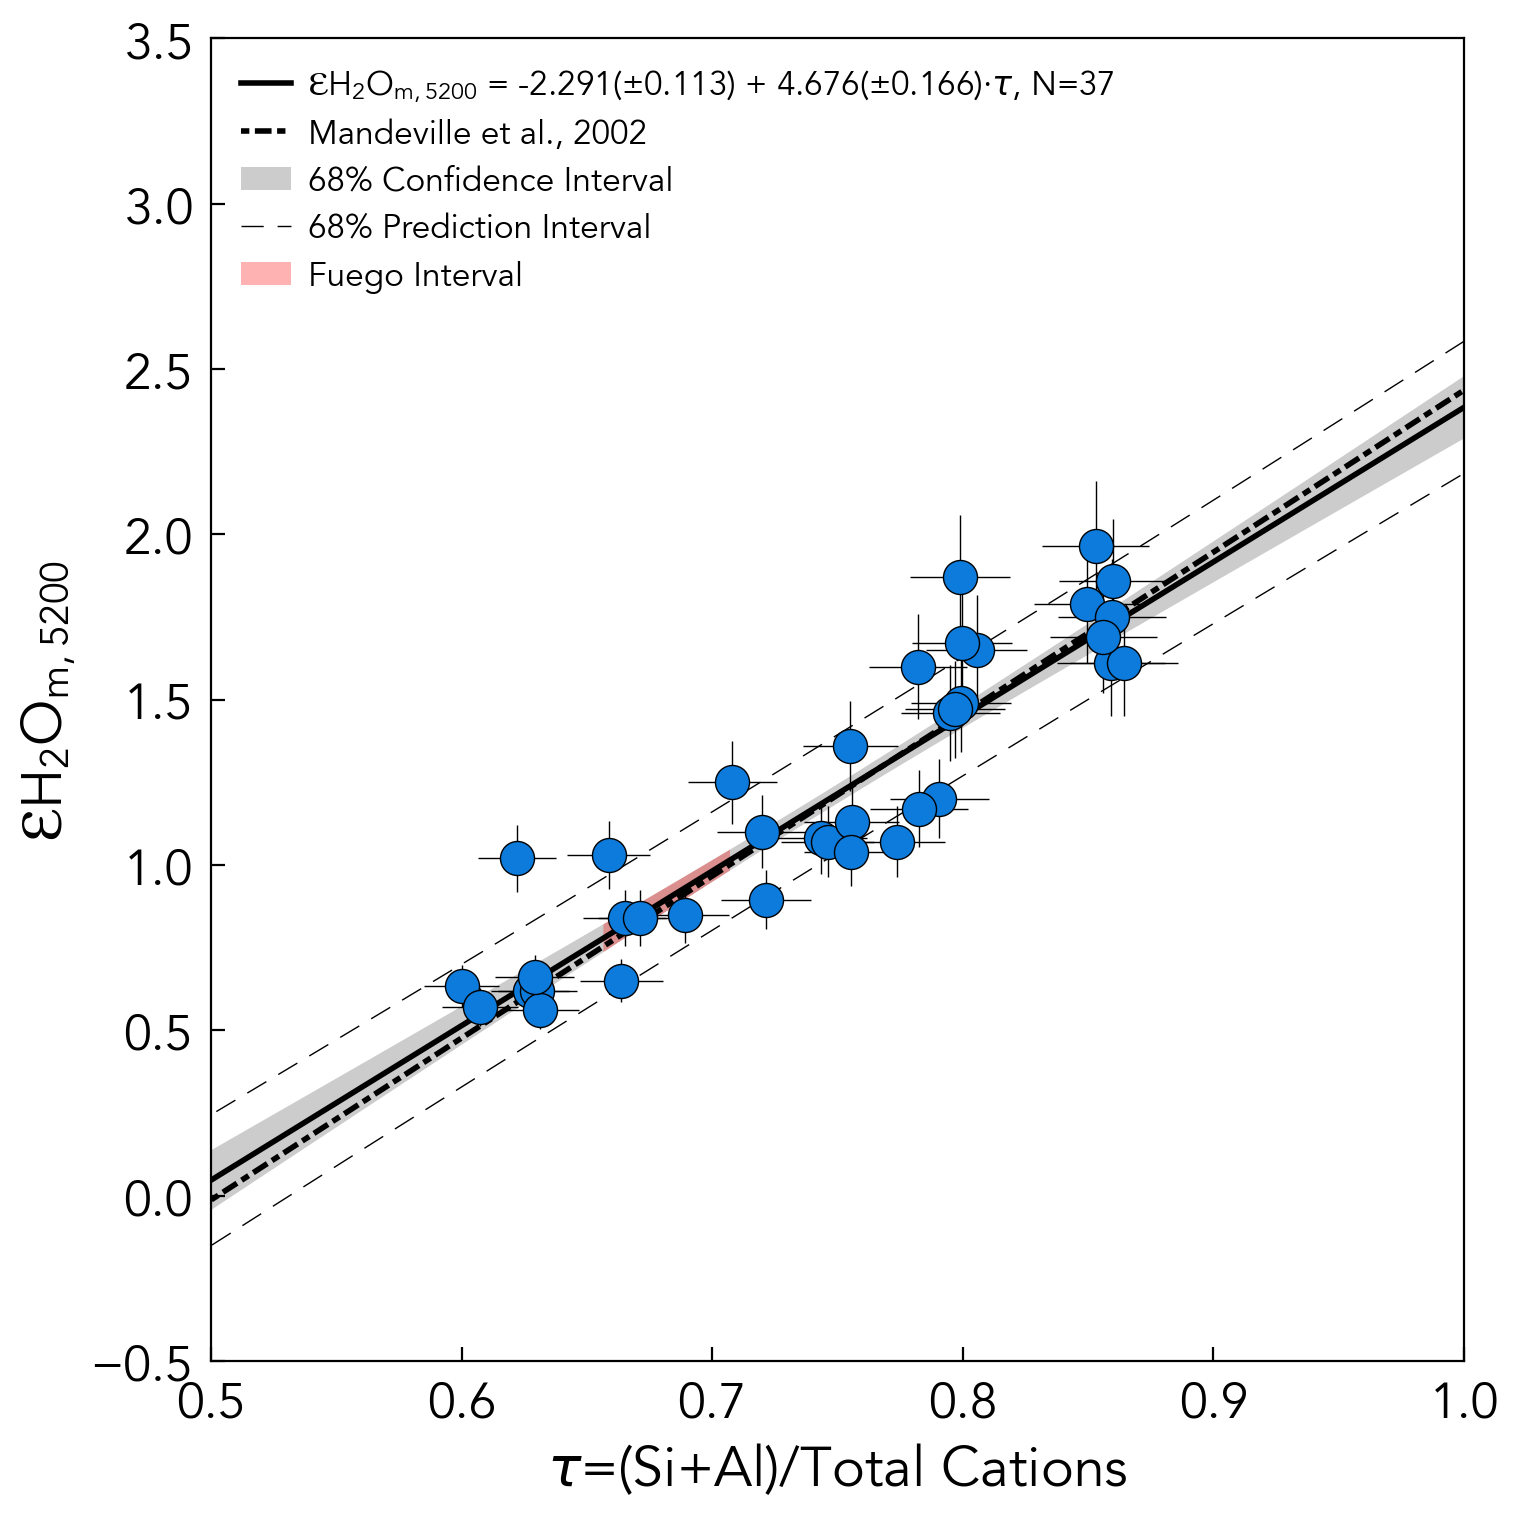

In [4]:
epsilon_5200_mandeville = -2.463 + 4.899*tau_arr_5200
# linex_f = linspace(0.653, 0.715, 5); 

fuego_idx = np.where((tau_arr_5200 > 0.653) & (tau_arr_5200 < 0.715))

legend_5200 = '$\mathregular{ƐH_2O_{m, 5200}}$ = ' + f'{round(mest_5200[0],3)}(±{round(np.sqrt(np.diag(covm_est_5200))[0],3)}) + {round(mest_5200[1],3)}(±{round(np.sqrt(np.diag(covm_est_5200))[1],3)})'+ '·' + '$\\tau$'+ f', N={len(tau_5200)}'

sz = 150
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(tau_arr_5200, epsilon_5200_arr, 'k', lw = 2, zorder = 0, label = legend_5200)
mand, = ax.plot(tau_arr_5200, epsilon_5200_mandeville, 'k-.', lw = 2, zorder = 0, label = 'Mandeville et al., 2002')
mand.set_dashes([1.5, 1, 3, 1])
ax.fill_between(tau_arr_5200, conf_lower_5200, conf_upper_5200, color = 'k', alpha=0.20, edgecolor = None,
    zorder = -5, label='68% Confidence Interval')
ax.plot(tau_arr_5200, pred_upper_5200, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10))
ax.plot(tau_arr_5200, pred_lower_5200, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10), label = '68% Prediction Interval')
ax.fill_between(tau_arr_5200[fuego_idx], conf_lower_5200[fuego_idx], conf_upper_5200[fuego_idx], color = 'r', alpha=0.30,edgecolor = None, zorder = -5, label='Fuego Interval')
ax.errorbar(tau_5200, epsilon_5200, yerr = sigma_epsilon_5200, xerr = sigma_tau_5200, ls = 'none', elinewidth = 0.5, ecolor = 'k')
ax.scatter(tau_5200, epsilon_5200, s = sz, c = '#0C7BDC', edgecolors='black', linewidth = 0.5, zorder = 15)
ax.set_xlim([ 0.5, 1.0])
ax.set_ylim([-0.5, 3.5])
xlabel_5200 = '$\\tau$='+'(Si+Al)/Total Cations'

ax.set_xlabel(xlabel_5200)
ax.set_ylabel('$\mathregular{ƐH_2O_{m, 5200}}$')

ax.legend(loc = 'upper left', labelspacing = 0.4, handletextpad = 0.5, handlelength = 1.50, prop={'size': 12}, frameon=False)
ax.tick_params(axis="x", direction='in', length=5, pad = 6.5)
ax.tick_params(axis="y", direction='in', length=5, pad = 6.5)
plt.tight_layout()
plt.savefig('Epsilon5200Regress.pdf')

meta NOT subset; don't know how to subset; dropped


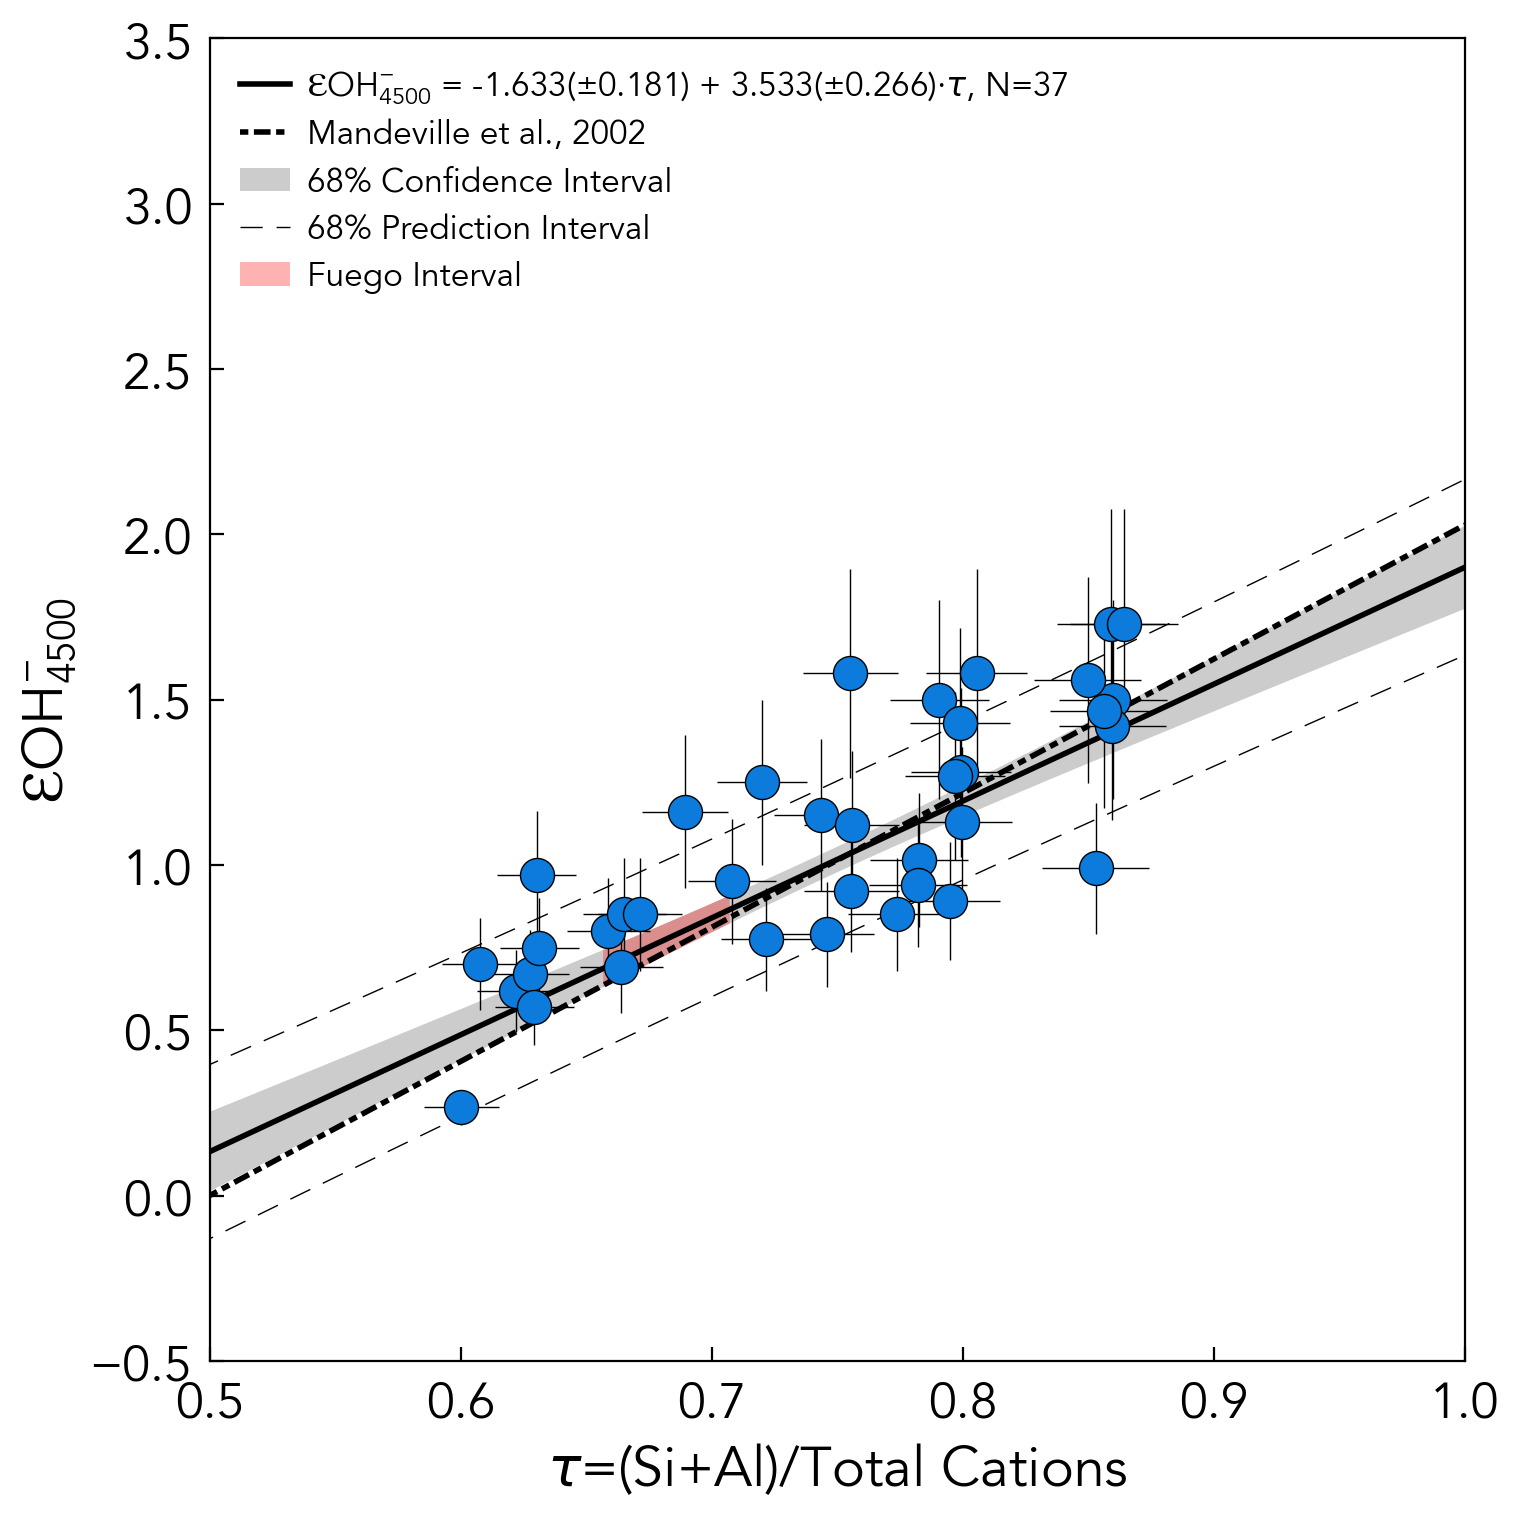

In [5]:
epsilon_4500_mandeville = -2.026+4.054*tau_arr_4500

fuego_idx = np.where((tau_arr_4500 > 0.653) & (tau_arr_4500 < 0.715))

legend_4500 = '$\mathregular{ƐOH^{-}_{4500}}$ = ' + f'{round(mest_4500[0],3)}(±{round(np.sqrt(np.diag(covm_est_4500))[0],3)}) + {round(mest_4500[1],3)}(±{round(np.sqrt(np.diag(covm_est_4500))[1],3)})'+ '·' + '$\\tau$'+ f', N={len(tau_4500)}'

sz = 150
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(tau_arr_4500, epsilon_4500_arr, 'k', lw = 2, zorder = 0, label = legend_4500)
mand, = ax.plot(tau_arr_4500, epsilon_4500_mandeville, 'k-.', lw = 2, zorder = 0, label = 'Mandeville et al., 2002')
mand.set_dashes([1.5, 1, 3, 1])
ax.fill_between(tau_arr_4500, conf_lower_4500, conf_upper_4500, color = 'k', alpha=0.20, edgecolor = None,
    zorder = -5, label='68% Confidence Interval')
ax.plot(tau_arr_4500, pred_upper_4500, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10))
ax.plot(tau_arr_4500, pred_lower_4500, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10), label = '68% Prediction Interval')
ax.fill_between(tau_arr_4500[fuego_idx], conf_lower_4500[fuego_idx], conf_upper_4500[fuego_idx], color = 'r', alpha=0.30,
    edgecolor = None, zorder = -5, label='Fuego Interval')
ax.errorbar(tau_4500, epsilon_4500, yerr = sigma_epsilon_4500, xerr = sigma_tau_4500, ls = 'none', elinewidth = 0.5, ecolor = 'k')
ax.scatter(tau_4500, epsilon_4500, s = sz, c = '#0C7BDC', edgecolors='black', linewidth = 0.5, zorder = 15)
ax.set_xlim([ 0.5, 1.0])
ax.set_ylim([-0.5, 3.5])
xlabel_4500 = '$\\tau$=' + '(Si+Al)/Total Cations'
ax.set_xlabel(xlabel_4500) 
ax.set_ylabel('$\mathregular{ƐOH^{-}_{4500}}$')
ax.legend(loc = 'upper left', labelspacing = 0.4, handletextpad = 0.5, handlelength = 1.50, prop={'size': 12}, frameon=False)
ax.tick_params(axis="x", direction='in', length=5, pad = 6.5)
ax.tick_params(axis="y", direction='in', length=5, pad = 6.5)
plt.tight_layout()
plt.savefig('Epsilon4500Regress.pdf')

meta NOT subset; don't know how to subset; dropped


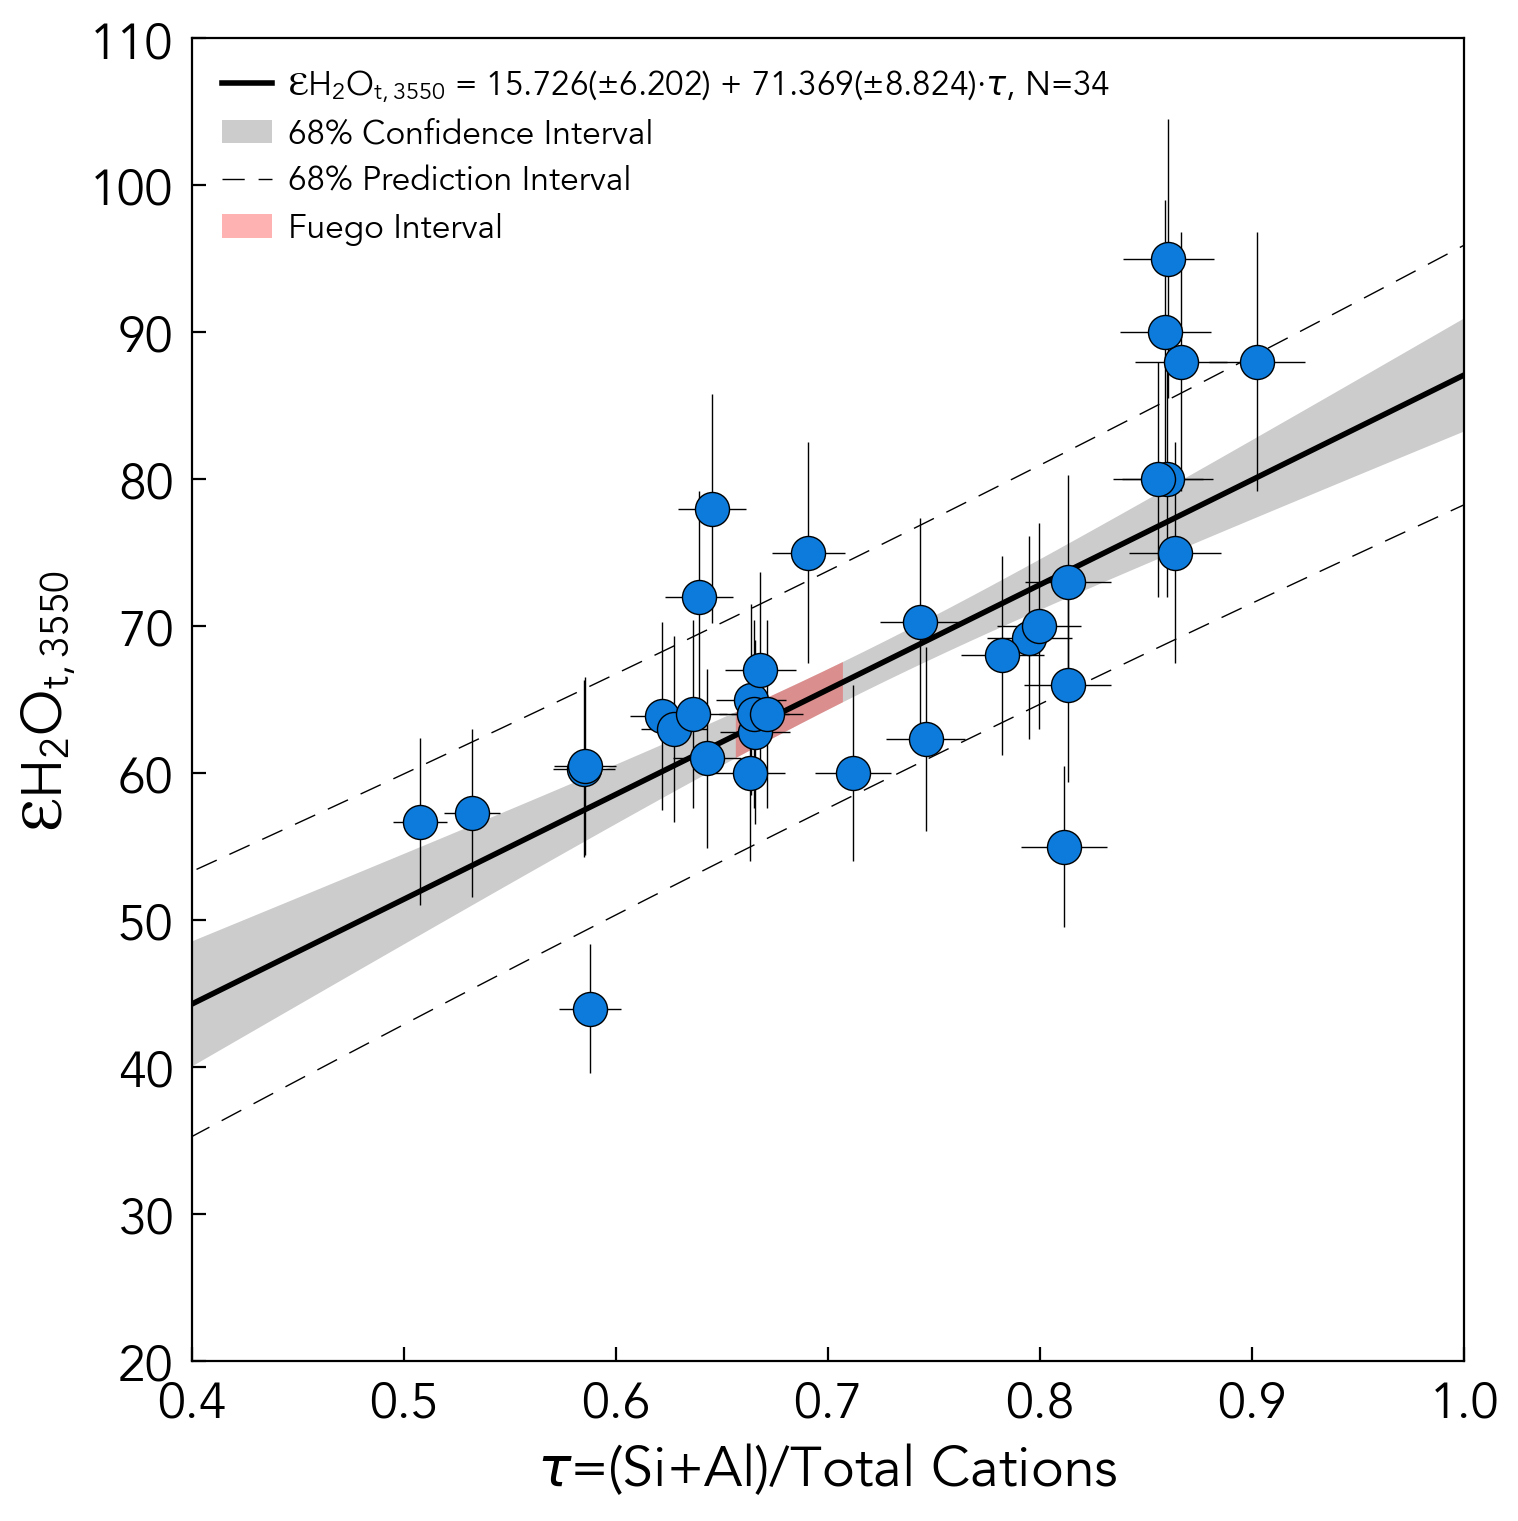

In [6]:
fuego_idx = np.where((tau_arr_3550 > 0.653) & (tau_arr_3550 < 0.715))

legend_3550 = '$\mathregular{ƐH_2O_{t, 3550}}$ = ' + f'{round(mest_3550[0],3)}(±{round(np.sqrt(np.diag(covm_est_3550))[0],3)}) + {round(mest_3550[1],3)}(±{round(np.sqrt(np.diag(covm_est_3550))[1],3)})'+ '·' + '$\\tau$'+ f', N={len(tau_3550)}'

sz = 150
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(tau_arr_3550, epsilon_3550_arr, 'k', lw = 2, zorder = 0, label = legend_3550)
mand.set_dashes([1.5, 1, 3, 1])
ax.fill_between(tau_arr_3550, conf_lower_3550, conf_upper_3550, color = 'k', alpha=0.20, edgecolor = None,
    zorder = -5, label='68% Confidence Interval')
ax.plot(tau_arr_3550, pred_upper_3550, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10))
ax.plot(tau_arr_3550, pred_lower_3550, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10), label = '68% Prediction Interval')
ax.fill_between(tau_arr_3550[fuego_idx], conf_lower_3550[fuego_idx], conf_upper_3550[fuego_idx], color = 'r', alpha=0.30,
    edgecolor = None, zorder = -5, label='Fuego Interval')
ax.errorbar(tau_3550, epsilon_3550, yerr = sigma_epsilon_3550, xerr = sigma_tau_3550, ls = 'none', elinewidth = 0.5, ecolor = 'k')
ax.scatter(tau_3550, epsilon_3550, s = sz, c = '#0C7BDC', edgecolors='black', linewidth = 0.5, zorder = 15)
ax.set_xlim([0.4, 1.0])
ax.set_ylim([20, 110])
xlabel_3550 = '$\\tau$=' + '(Si+Al)/Total Cations'
ax.set_xlabel(xlabel_3550) 
ax.set_ylabel('$\mathregular{ƐH_2O_{t, 3550}}$')
ax.legend(loc = 'upper left', labelspacing = 0.4, handletextpad = 0.5, handlelength = 1.50, prop={'size': 12}, frameon=False)
ax.tick_params(axis="x", direction='in', length=5, pad = 6.5)
ax.tick_params(axis="y", direction='in', length=5, pad = 6.5)
plt.tight_layout()
plt.savefig('Epsilon3550Regress.pdf')

meta NOT subset; don't know how to subset; dropped


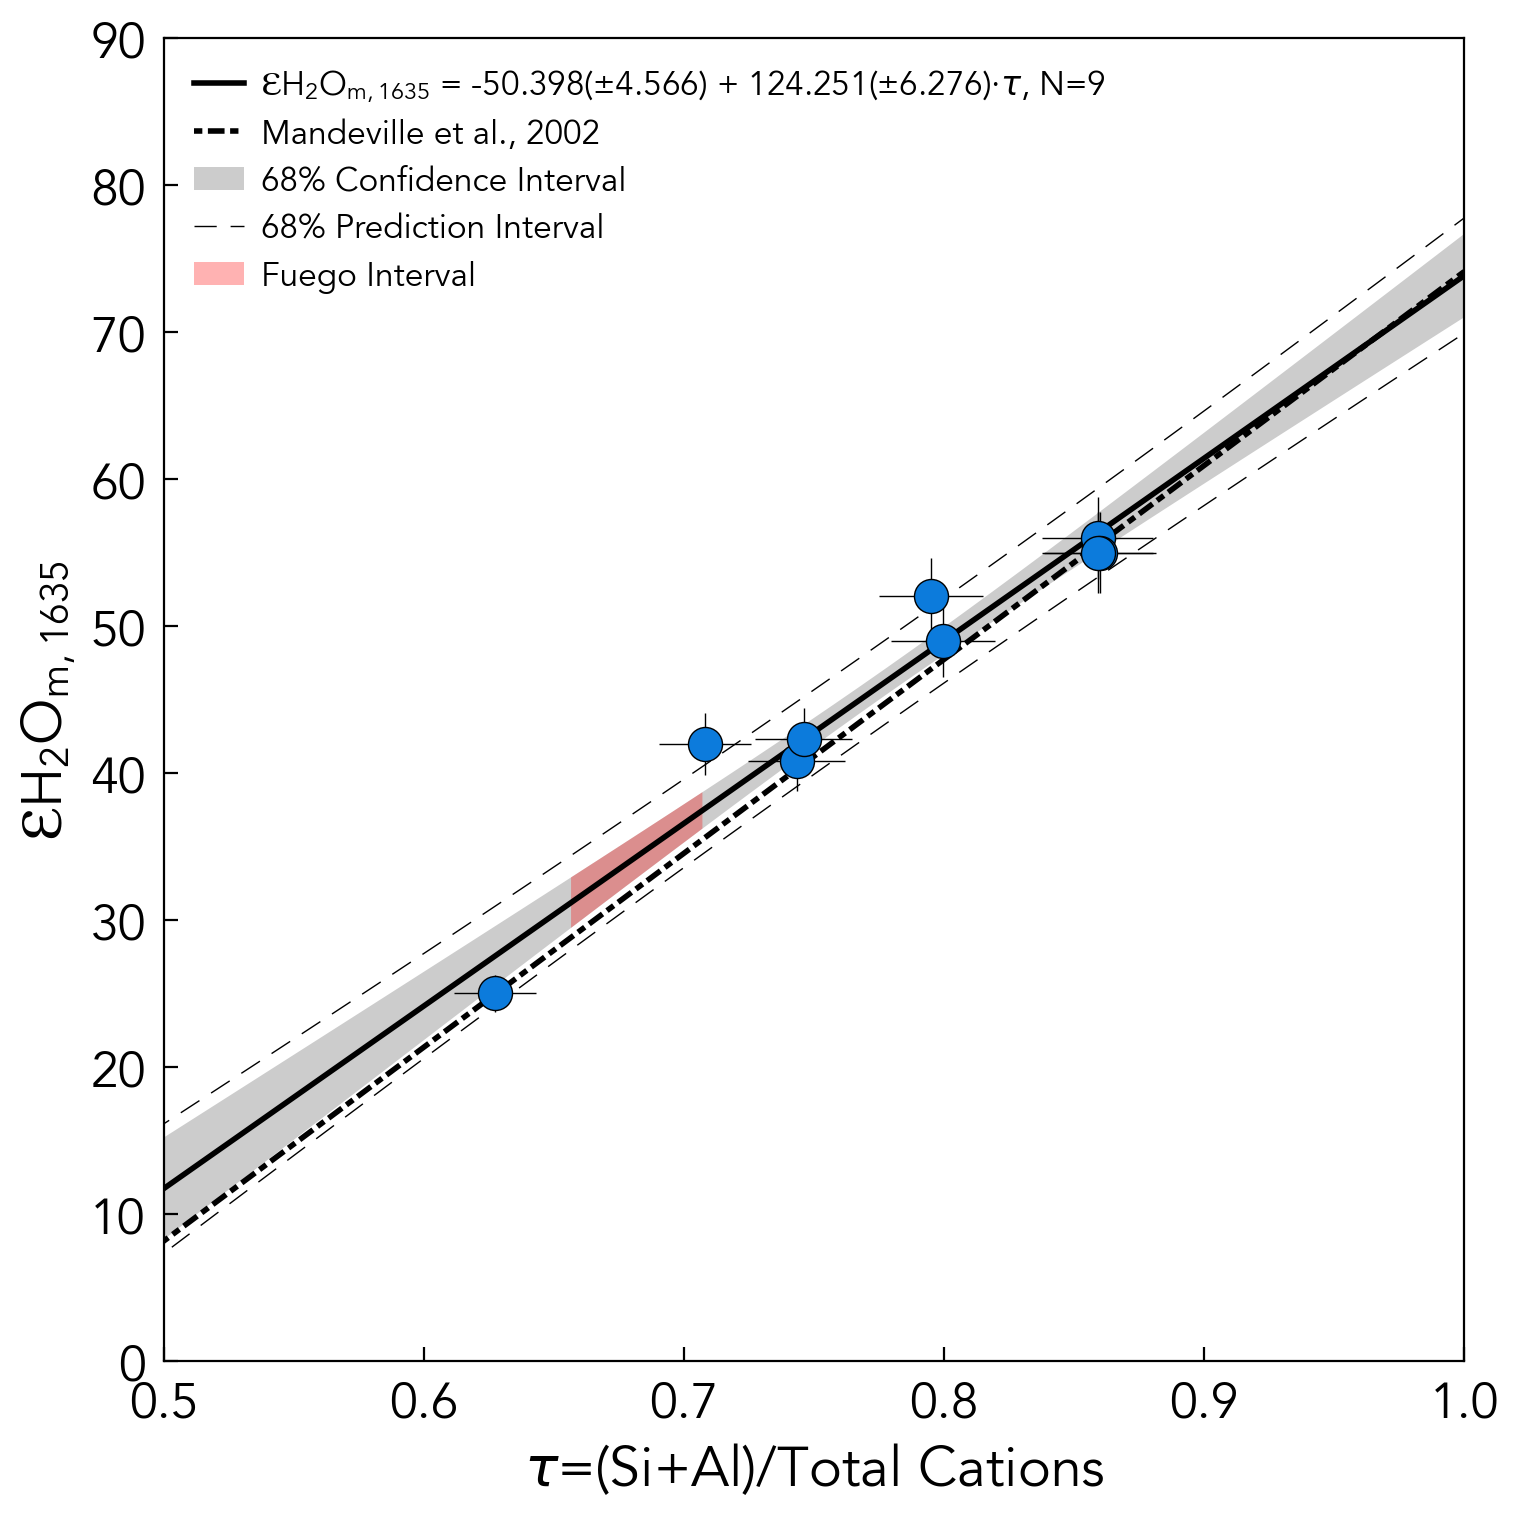

In [7]:
epsilon_1635_mandeville = -57.813+131.94*tau_arr_1635

fuego_idx = np.where((tau_arr_1635 > 0.653) & (tau_arr_1635 < 0.715))

legend_1635 = '$\mathregular{ƐH_2O_{m, 1635}}$ = ' + f'{round(mest_1635[0],3)}(±{round(np.sqrt(np.diag(covm_est_1635))[0],3)}) + {round(mest_1635[1],3)}(±{round(np.sqrt(np.diag(covm_est_1635))[1],3)})'+ '·' + '$\\tau$'+ f', N={len(tau_1635)}'

sz = 150
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax.plot(tau_arr_1635, epsilon_1635_arr, 'k', lw = 2, zorder = 0, label = legend_1635)
mand, = ax.plot(tau_arr_1635, epsilon_1635_mandeville, 'k-.', lw = 2, zorder = 0, label = 'Mandeville et al., 2002')
mand.set_dashes([1.5, 1, 3, 1])
ax.fill_between(tau_arr_1635, conf_lower_1635, conf_upper_1635, color = 'k', alpha=0.20, edgecolor = None,
    zorder = -5, label='68% Confidence Interval')
ax.plot(tau_arr_1635, pred_upper_1635, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10))
ax.plot(tau_arr_1635, pred_lower_1635, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10), label = '68% Prediction Interval')
ax.fill_between(tau_arr_1635[fuego_idx], conf_lower_1635[fuego_idx], conf_upper_1635[fuego_idx], color = 'r', alpha=0.30,
    edgecolor = None, zorder = -5, label='Fuego Interval')
ax.errorbar(tau_1635, epsilon_1635, yerr = sigma_epsilon_1635, xerr = sigma_tau_1635, ls = 'none', elinewidth = 0.5, ecolor = 'k')
ax.scatter(tau_1635, epsilon_1635, s = sz, c = '#0C7BDC', edgecolors='black', linewidth = 0.5, zorder = 15)
ax.set_xlim([0.5, 1.0])
ax.set_ylim([0, 90])
xlabel_1635 = '$\\tau$=' + '(Si+Al)/Total Cations'
ax.set_xlabel(xlabel_1635) 
ax.set_ylabel('$\mathregular{ƐH_2O_{m, 1635}}$')

ax.legend(loc = 'upper left', labelspacing = 0.4, handletextpad = 0.5, handlelength = 1.50, prop={'size': 12}, frameon=False)
ax.tick_params(axis="x", direction='in', length=5, pad = 6.5)
ax.tick_params(axis="y", direction='in', length=5, pad = 6.5)
plt.tight_layout()
plt.savefig('Epsilon1635Regress.pdf')

meta NOT subset; don't know how to subset; dropped


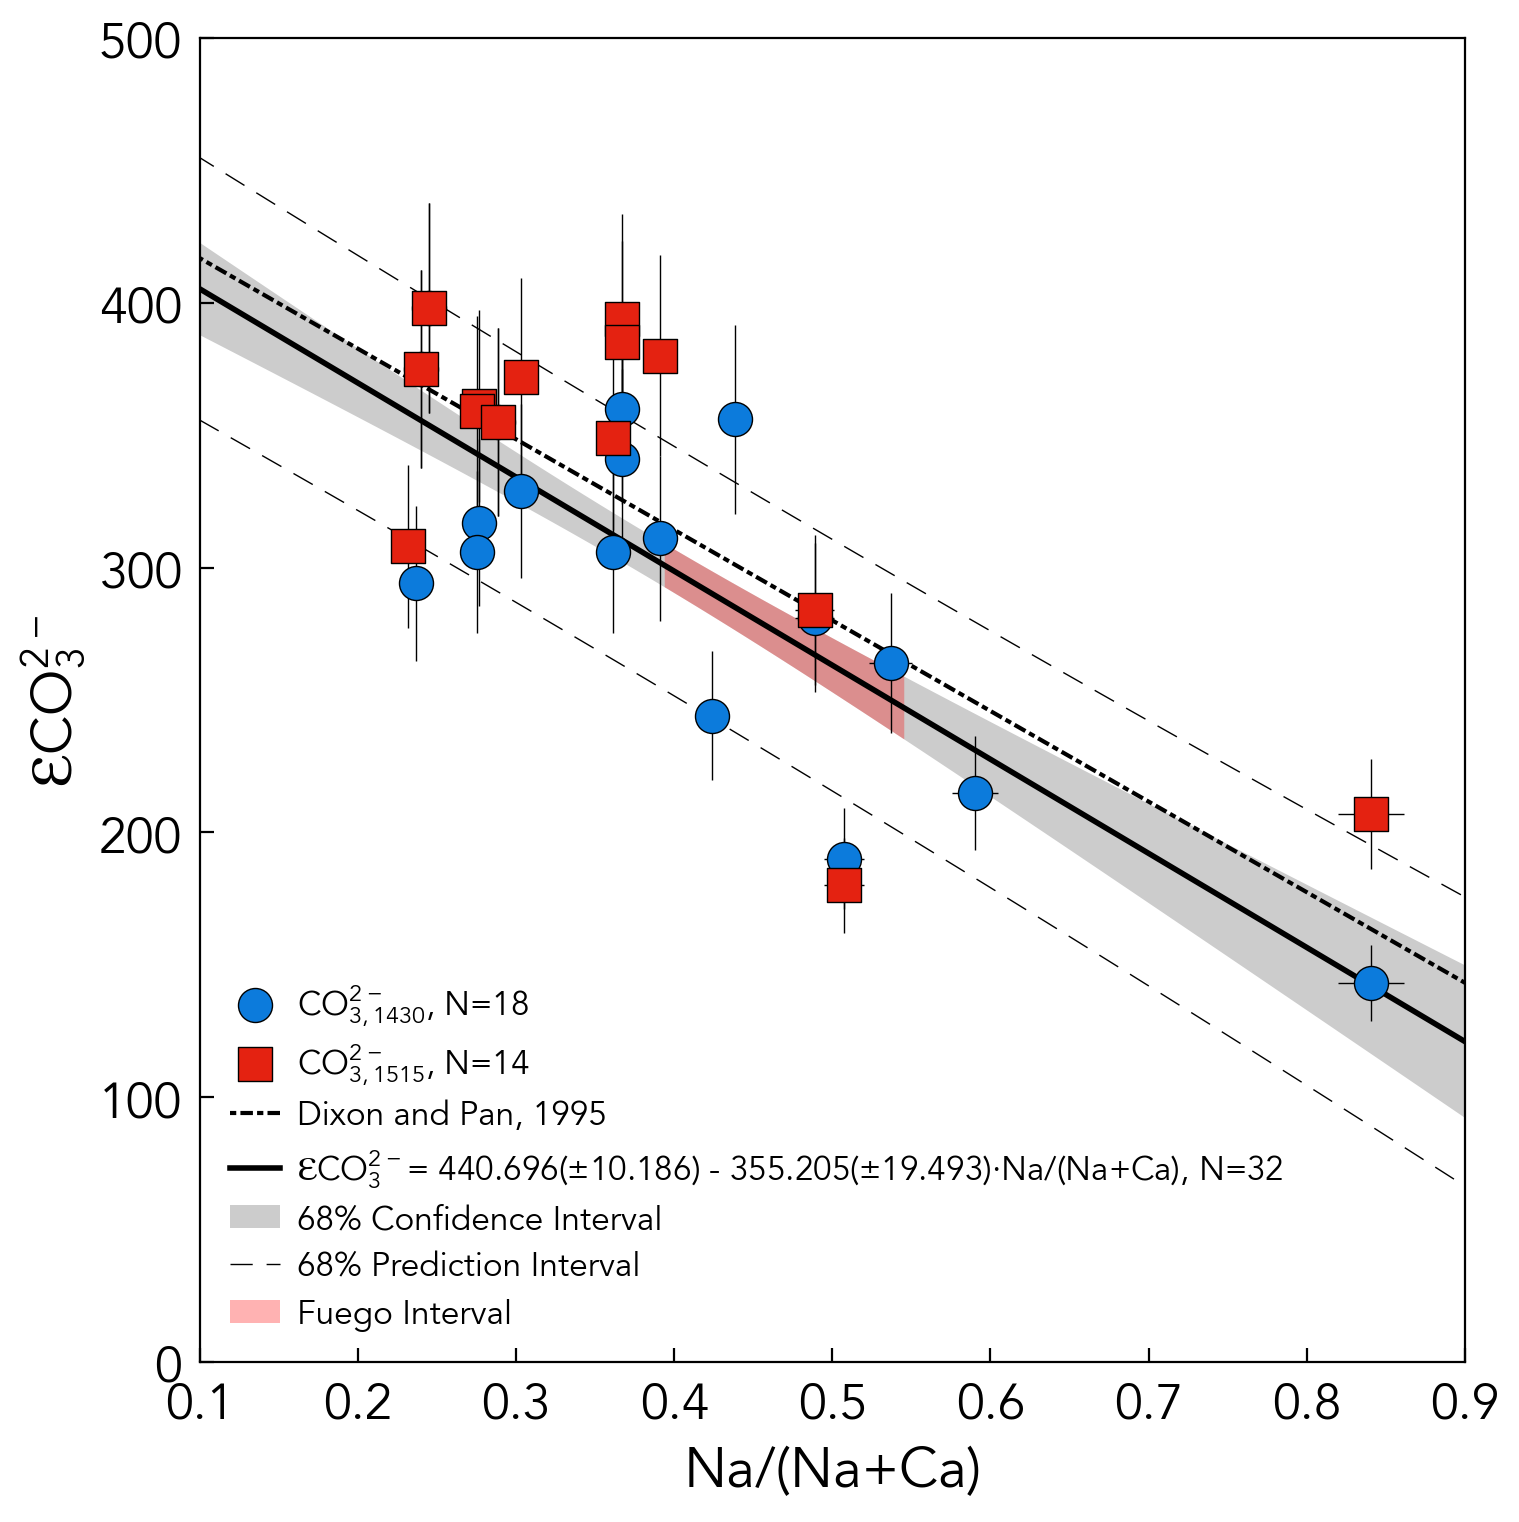

In [8]:
epsilon_carbonate_dixonpan = 451-342*naca_arr

fuego_idx = np.where((naca_arr > 0.389) & (naca_arr < 0.554))

df_carbonate = pd.read_excel('./EpsilonRegression.xlsx', sheet_name='CarbonateRegress')

low_df = df_carbonate[df_carbonate.Epsilon_Location == 'Low']
high_df = df_carbonate[df_carbonate.Epsilon_Location == 'High']

sz = 150
fig, ax = plt.subplots(1, 1, figsize = (8, 8))

ax.errorbar(low_df['Na/Na+Ca'], low_df['Epsilon_Carbonate'], yerr = low_df['Epsilon_Carbonate']*0.1, xerr = low_df['Na/Na+Ca']*0.025, ls = 'none', elinewidth = 0.5, ecolor = 'k')
ax.scatter(low_df['Na/Na+Ca'], low_df['Epsilon_Carbonate'], s = sz, c = '#0C7BDC', edgecolors='black', linewidth = 0.5, zorder = 15, label = '$\mathregular{CO_{3, 1430}^{2-}}$, N='+str(len(low_df)))

ax.errorbar(high_df['Na/Na+Ca'], high_df['Epsilon_Carbonate'], yerr = high_df['Epsilon_Carbonate']*0.10, xerr = high_df['Na/Na+Ca']*0.025, ls = 'none', elinewidth = 0.5, ecolor = 'k')
ax.scatter(high_df['Na/Na+Ca'], high_df['Epsilon_Carbonate'], s = sz, c = '#E42211', marker = 's', edgecolors='black', linewidth = 0.5, zorder = 15, label = '$\mathregular{CO_{3, 1515}^{2-}}$, N='+str(len(high_df)))

dixonpan, = ax.plot(naca_arr, epsilon_carbonate_dixonpan, 'k-.', lw = 1.5, zorder = 0, label = 'Dixon and Pan, 1995')
dixonpan.set_dashes([1.5, 1, 3, 1])
legend_carbonate = '$\mathregular{ƐCO_3^{2-}}$= ' + f'{round(mest_carbonate[0],3)}(±{round(np.sqrt(np.diag(covm_est_carbonate))[0],3)}) - {round(mest_carbonate[1],3)*-1}(±{round(np.sqrt(np.diag(covm_est_carbonate))[1],3)})' + '·' + f'Na/(Na+Ca), N={len(naca)}'
ax.plot(naca_arr, epsilon_carbonate_arr, 'k', lw = 2, zorder = 0, label = legend_carbonate)
ax.fill_between(naca_arr, conf_lower_carbonate, conf_upper_carbonate, color = 'k', alpha=0.20, edgecolor = None,
    zorder = -5, label='68% Confidence Interval')
ax.plot(naca_arr, pred_upper_carbonate, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10))
ax.plot(naca_arr, pred_lower_carbonate, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10), label = '68% Prediction Interval')
ax.fill_between(naca_arr[fuego_idx], conf_lower_carbonate[fuego_idx], conf_upper_carbonate[fuego_idx], color = 'r', alpha=0.30, edgecolor = None,
    zorder = -5, label='Fuego Interval')
ax.set_xlim([0.1, 0.9])
ax.set_ylim([0, 500])
ax.set_xlabel('Na/(Na+Ca)') 
ax.set_ylabel('$\mathregular{ƐCO_3^{2-}}$')

ax.legend(loc = 'lower left', labelspacing = 0.4, handletextpad = 0.5, handlelength = 1.50, prop={'size': 12}, frameon=False)
ax.tick_params(axis="x", direction='in', length=5, pad = 6.5)
ax.tick_params(axis="y", direction='in', length=5, pad = 6.5)
plt.tight_layout()
plt.savefig('EpsilonCarbonateRegress.pdf')

meta NOT subset; don't know how to subset; dropped


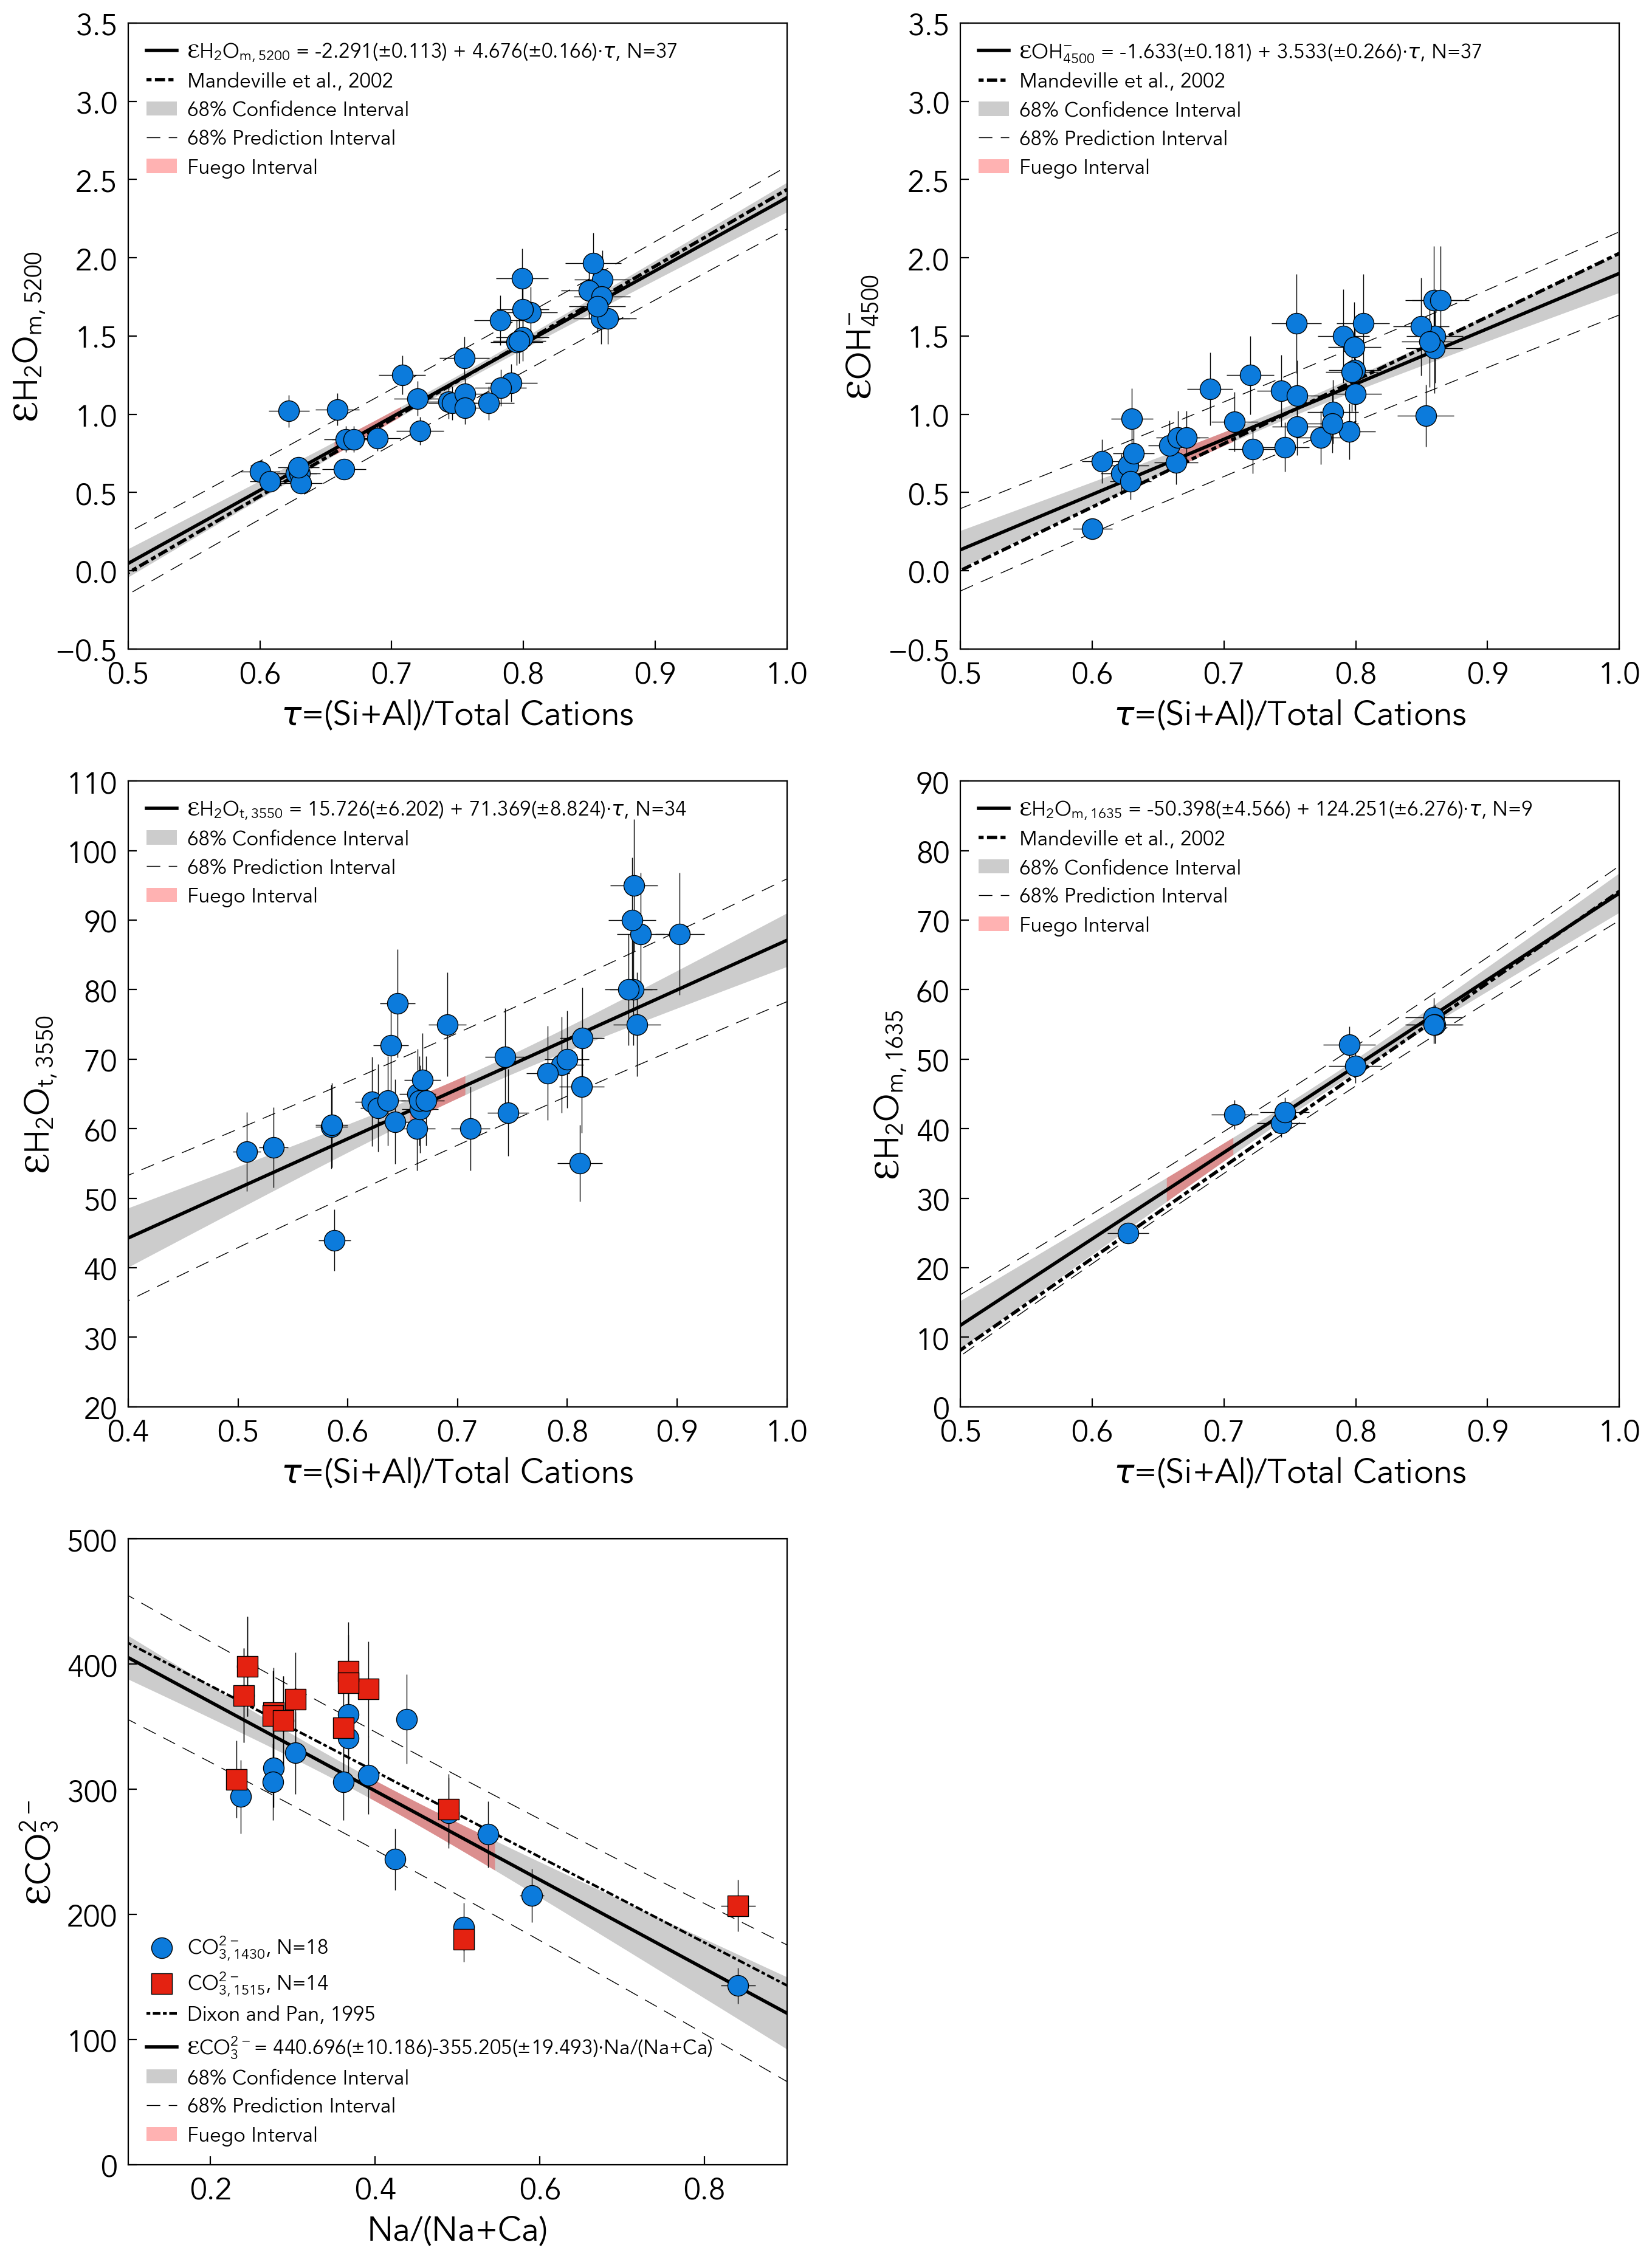

In [9]:
sz = 150

fig, ax = plt.subplots(3, 2, figsize = (14, 19))
ax = ax.flatten()

epsilon_5200_mandeville = -2.463 + 4.899*tau_arr_5200

fuego_idx = np.where((tau_arr_5200 > 0.653) & (tau_arr_5200 < 0.715))

legend_5200 = '$\mathregular{ƐH_2O_{m, 5200}}$ = ' + f'{round(mest_5200[0],3)}(±{round(np.sqrt(np.diag(covm_est_5200))[0],3)}) + {round(mest_5200[1],3)}(±{round(np.sqrt(np.diag(covm_est_5200))[1],3)})'+ '·' + '$\\tau$'+ f', N={len(tau_5200)}'

ax[0].plot(tau_arr_5200, epsilon_5200_arr, 'k', lw = 2, zorder = 0, label = legend_5200)
mand, = ax[0].plot(tau_arr_5200, epsilon_5200_mandeville, 'k-.', lw = 2, zorder = 0, label = 'Mandeville et al., 2002')
mand.set_dashes([1.5, 1, 3, 1])
ax[0].fill_between(tau_arr_5200, conf_lower_5200, conf_upper_5200, color = 'k', alpha=0.20, edgecolor = None,
    zorder = -5, label='68% Confidence Interval')
ax[0].plot(tau_arr_5200, pred_upper_5200, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10))
ax[0].plot(tau_arr_5200, pred_lower_5200, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10), label = '68% Prediction Interval')
ax[0].fill_between(tau_arr_5200[fuego_idx], conf_lower_5200[fuego_idx], conf_upper_5200[fuego_idx], color = 'r', alpha=0.30,
    edgecolor = None, zorder = -5, label='Fuego Interval')
ax[0].errorbar(tau_5200, epsilon_5200, yerr = sigma_epsilon_5200, xerr = sigma_tau_5200, ls = 'none', elinewidth = 0.5, ecolor = 'k')
ax[0].scatter(tau_5200, epsilon_5200, s = sz, c = '#0C7BDC', edgecolors='black', linewidth = 0.5, zorder = 15)
ax[0].set_xlim([ 0.5, 1.0])
ax[0].set_ylim([-0.5, 3.5])
xlabel_5200 = '$\\tau$='+'(Si+Al)/Total Cations'
ax[0].set_xlabel(xlabel_5200)
ax[0].set_ylabel('$\mathregular{ƐH_2O_{m, 5200}}$')
ax[0].legend(loc = 'upper left', labelspacing = 0.4, handletextpad = 0.5, handlelength = 1.50, prop={'size': 12}, frameon=False)
ax[0].tick_params(axis="x", direction='in', length=5, pad = 6.5)
ax[0].tick_params(axis="y", direction='in', length=5, pad = 6.5)


epsilon_4500_mandeville = -2.026+4.054*tau_arr_4500

fuego_idx = np.where((tau_arr_4500 > 0.653) & (tau_arr_4500 < 0.715))
legend_4500 = '$\mathregular{ƐOH^{-}_{4500}}$ = ' + f'{round(mest_4500[0],3)}(±{round(np.sqrt(np.diag(covm_est_4500))[0],3)}) + {round(mest_4500[1],3)}(±{round(np.sqrt(np.diag(covm_est_4500))[1],3)})'+ '·' + '$\\tau$'+ f', N={len(tau_4500)}'

ax[1].plot(tau_arr_4500, epsilon_4500_arr, 'k', lw = 2, zorder = 0, label = legend_4500)
mand, = ax[1].plot(tau_arr_4500, epsilon_4500_mandeville, 'k-.', lw = 2, zorder = 0, label = 'Mandeville et al., 2002')
mand.set_dashes([1.5, 1, 3, 1])
ax[1].fill_between(tau_arr_4500, conf_lower_4500, conf_upper_4500, color = 'k', alpha=0.20, edgecolor = None,
    zorder = -5, label='68% Confidence Interval')
ax[1].plot(tau_arr_4500, pred_upper_4500, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10))
ax[1].plot(tau_arr_4500, pred_lower_4500, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10), label = '68% Prediction Interval')
ax[1].fill_between(tau_arr_4500[fuego_idx], conf_lower_4500[fuego_idx], conf_upper_4500[fuego_idx], color = 'r', alpha=0.30,
    edgecolor = None, zorder = -5, label='Fuego Interval')
ax[1].errorbar(tau_4500, epsilon_4500, yerr = sigma_epsilon_4500, xerr = sigma_tau_4500, ls = 'none', elinewidth = 0.5, ecolor = 'k')
ax[1].scatter(tau_4500, epsilon_4500, s = sz, c = '#0C7BDC', edgecolors='black', linewidth = 0.5, zorder = 15)
ax[1].set_xlim([ 0.5, 1.0])
ax[1].set_ylim([-0.5, 3.5])
xlabel_4500 = '$\\tau$=' + '(Si+Al)/Total Cations'
ax[1].set_xlabel(xlabel_4500) 
ax[1].set_ylabel('$\mathregular{ƐOH^{-}_{4500}}$')
ax[1].legend(loc = 'upper left', labelspacing = 0.4, handletextpad = 0.5, handlelength = 1.50, prop={'size': 12}, frameon=False)
ax[1].tick_params(axis="x", direction='in', length=5, pad = 6.5)
ax[1].tick_params(axis="y", direction='in', length=5, pad = 6.5)


fuego_idx = np.where((tau_arr_3550 > 0.653) & (tau_arr_3550 < 0.715))
legend_3550 = '$\mathregular{ƐH_2O_{t, 3550}}$ = ' + f'{round(mest_3550[0],3)}(±{round(np.sqrt(np.diag(covm_est_3550))[0],3)}) + {round(mest_3550[1],3)}(±{round(np.sqrt(np.diag(covm_est_3550))[1],3)})'+ '·' + '$\\tau$'+ f', N={len(tau_3550)}'

ax[2].plot(tau_arr_3550, epsilon_3550_arr, 'k', lw = 2, zorder = 0, label = legend_3550)
mand.set_dashes([1.5, 1, 3, 1])
ax[2].fill_between(tau_arr_3550, conf_lower_3550, conf_upper_3550, color = 'k', alpha=0.20, edgecolor = None,
    zorder = -5, label='68% Confidence Interval')
ax[2].plot(tau_arr_3550, pred_upper_3550, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10))
ax[2].plot(tau_arr_3550, pred_lower_3550, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10), label = '68% Prediction Interval')
ax[2].fill_between(tau_arr_3550[fuego_idx], conf_lower_3550[fuego_idx], conf_upper_3550[fuego_idx], color = 'r', alpha=0.30,
    edgecolor = None, zorder = -5, label='Fuego Interval')
ax[2].errorbar(tau_3550, epsilon_3550, yerr = sigma_epsilon_3550, xerr = sigma_tau_3550, ls = 'none', elinewidth = 0.5, ecolor = 'k')
ax[2].scatter(tau_3550, epsilon_3550, s = sz, c = '#0C7BDC', edgecolors='black', linewidth = 0.5, zorder = 15)
ax[2].set_xlim([0.4, 1.0])
ax[2].set_ylim([20, 110])
xlabel_3550 = '$\\tau$=' + '(Si+Al)/Total Cations'
ax[2].set_xlabel(xlabel_3550) 
ax[2].set_ylabel('$\mathregular{ƐH_2O_{t, 3550}}$')
ax[2].legend(loc = 'upper left', labelspacing = 0.4, handletextpad = 0.5, handlelength = 1.50, prop={'size': 12}, frameon=False)
ax[2].tick_params(axis="x", direction='in', length=5, pad = 6.5)
ax[2].tick_params(axis="y", direction='in', length=5, pad = 6.5)


epsilon_1635_mandeville = -57.813+131.94*tau_arr_1635

fuego_idx = np.where((tau_arr_1635 > 0.653) & (tau_arr_1635 < 0.715))
legend_1635 = '$\mathregular{ƐH_2O_{m, 1635}}$ = ' + f'{round(mest_1635[0],3)}(±{round(np.sqrt(np.diag(covm_est_1635))[0],3)}) + {round(mest_1635[1],3)}(±{round(np.sqrt(np.diag(covm_est_1635))[1],3)})'+ '·' + '$\\tau$'+ f', N={len(tau_1635)}'

ax[3].plot(tau_arr_1635, epsilon_1635_arr, 'k', lw = 2, zorder = 0, label = legend_1635)
mand, = ax[3].plot(tau_arr_1635, epsilon_1635_mandeville, 'k-.', lw = 2, zorder = 0, label = 'Mandeville et al., 2002')
mand.set_dashes([1.5, 1, 3, 1])
ax[3].fill_between(tau_arr_1635, conf_lower_1635, conf_upper_1635, color = 'k', alpha=0.20, edgecolor = None,
    zorder = -5, label='68% Confidence Interval')
ax[3].plot(tau_arr_1635, pred_upper_1635, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10))
ax[3].plot(tau_arr_1635, pred_lower_1635, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10), label = '68% Prediction Interval')
ax[3].fill_between(tau_arr_1635[fuego_idx], conf_lower_1635[fuego_idx], conf_upper_1635[fuego_idx], color = 'r', alpha=0.30,
    edgecolor = None, zorder = -5, label='Fuego Interval')
ax[3].errorbar(tau_1635, epsilon_1635, yerr = sigma_epsilon_1635, xerr = sigma_tau_1635, ls = 'none', elinewidth = 0.5, ecolor = 'k')
ax[3].scatter(tau_1635, epsilon_1635, s = sz, c = '#0C7BDC', edgecolors='black', linewidth = 0.5, zorder = 15)
ax[3].set_xlim([0.5, 1.0])
ax[3].set_ylim([0, 90])
xlabel_1635 = '$\\tau$=' + '(Si+Al)/Total Cations'
ax[3].set_xlabel(xlabel_1635) 
ax[3].set_ylabel('$\mathregular{ƐH_2O_{m, 1635}}$')
ax[3].legend(loc = 'upper left', labelspacing = 0.4, handletextpad = 0.5, handlelength = 1.50, prop={'size': 12}, frameon=False)
ax[3].tick_params(axis="x", direction='in', length=5, pad = 6.5)
ax[3].tick_params(axis="y", direction='in', length=5, pad = 6.5)

epsilon_carbonate_dixonpan = 451-342*naca_arr

fuego_idx = np.where((naca_arr > 0.389) & (naca_arr < 0.554))

df_carbonate = pd.read_excel('./EpsilonRegression.xlsx', sheet_name='CarbonateRegress')

low_df = df_carbonate[df_carbonate.Epsilon_Location == 'Low']
high_df = df_carbonate[df_carbonate.Epsilon_Location == 'High']

ax[4].errorbar(low_df['Na/Na+Ca'], low_df['Epsilon_Carbonate'], yerr = low_df['Epsilon_Carbonate']*0.1, xerr = low_df['Na/Na+Ca']*0.025, ls = 'none', elinewidth = 0.5, ecolor = 'k')
ax[4].scatter(low_df['Na/Na+Ca'], low_df['Epsilon_Carbonate'], s = sz, c = '#0C7BDC', edgecolors='black', linewidth = 0.5, zorder = 15, label = '$\mathregular{CO_{3, 1430}^{2-}}$, N='+str(len(low_df)))

ax[4].errorbar(high_df['Na/Na+Ca'], high_df['Epsilon_Carbonate'], yerr = high_df['Epsilon_Carbonate']*0.10, xerr = high_df['Na/Na+Ca']*0.025, ls = 'none', elinewidth = 0.5, ecolor = 'k')
ax[4].scatter(high_df['Na/Na+Ca'], high_df['Epsilon_Carbonate'], s = sz, c = '#E42211', marker = 's', edgecolors='black', linewidth = 0.5, zorder = 15, label = '$\mathregular{CO_{3, 1515}^{2-}}$, N='+str(len(high_df)))

dixonpan, = ax[4].plot(naca_arr, epsilon_carbonate_dixonpan, 'k-.', lw = 1.5, zorder = 0, label = 'Dixon and Pan, 1995')
dixonpan.set_dashes([1.5, 1, 3, 1])
legend_carbonate = '$\mathregular{ƐCO_3^{2-}}$= ' + f'{round(mest_carbonate[0],3)}(±{round(np.sqrt(np.diag(covm_est_carbonate))[0],3)})-{round(mest_carbonate[1],3)*-1}(±{round(np.sqrt(np.diag(covm_est_carbonate))[1],3)})' + '·' + f'Na/(Na+Ca)'
ax[4].plot(naca_arr, epsilon_carbonate_arr, 'k', lw = 2, zorder = 0, label = legend_carbonate)
ax[4].fill_between(naca_arr, conf_lower_carbonate, conf_upper_carbonate, color = 'k', alpha=0.20, edgecolor = None,
    zorder = -5, label='68% Confidence Interval')
ax[4].plot(naca_arr, pred_upper_carbonate, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10))
ax[4].plot(naca_arr, pred_lower_carbonate, 'k--', lw = 0.5, zorder = 0, dashes=(16, 10), label = '68% Prediction Interval')
ax[4].fill_between(naca_arr[fuego_idx], conf_lower_carbonate[fuego_idx], conf_upper_carbonate[fuego_idx], color = 'r', alpha=0.30, edgecolor = None,
    zorder = -5, label='Fuego Interval')
ax[4].set_xlim([0.1, 0.9])
ax[4].set_ylim([0, 500])
ax[4].set_xlabel('Na/(Na+Ca)') 
ax[4].set_ylabel('$\mathregular{ƐCO_3^{2-}}$')
ax[4].legend(loc = 'lower left', labelspacing = 0.4, handletextpad = 0.5, handlelength = 1.50, prop={'size': 12}, frameon=False)
ax[4].tick_params(axis="x", direction='in', length=5, pad = 6.5)
ax[4].tick_params(axis="y", direction='in', length=5, pad = 6.5)

fig.delaxes(ax[5])

plt.tight_layout()
plt.savefig('AllEpsilonRegress.pdf')